In [8]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../data/raw/sh_hotel.csv', index_col=0, parse_dates=True)
scalar = StandardScaler()
df_new = pd.DataFrame(scalar.fit_transform(df),index=df.index,columns=df.columns)
df_new = df_new.reindex(pd.date_range(start=df.index.min(), end=pd.to_datetime('2025-04-01'), freq='MS'))
num_samples = df_new.shape[0]
num_features = df_new.shape[1]

In [2]:
from pygrinder import mcar

X = df_new.values  # drop date column
X = X.reshape(1, num_samples, -1)
X_ori = X  # keep X_ori for validation

X = mcar(X, 0.1)
dataset = {"X": X}  # X for model input

In [3]:
from pypots.optim import Adam
from pypots.imputation import Transformer

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

transformer = Transformer(
    n_steps=num_samples,
    n_features=num_features,
    n_layers=4,
    d_model=128,
    d_ffn=128,
    n_heads=4,
    d_k=32,
    d_v=64,
    dropout=0.05,
    attn_dropout=0,
    epochs=200,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # Set it to None to use the default device (will use CPU if you don't have CUDA devices).
    # You can also set it to 'cpu' or 'cuda' explicitly, or ['cuda:0', 'cuda:1'] if you have multiple CUDA devices.
    device=device,
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
transformer.fit(dataset)
# the testing stage, impute the originally-missing values and artificially-missing values in the test set
imputation = transformer.impute(dataset)

2024-05-08 22:27:34 [ERROR]: ❌ No module named 'torch_geometric'
Note torch_geometric is missing, please install it with 'pip install torch_geometric torch_scatter torch_sparse' or 'conda install -c pyg pyg pytorch-scatter pytorch-sparse'
2024-05-08 22:27:34 [ERROR]: ❌ name 'MessagePassing' is not defined
Note torch_geometric is missing, please install it with 'pip install torch_geometric torch_scatter torch_sparse' or 'conda install -c pyg pyg pytorch-scatter pytorch-sparse'
2024-05-08 22:27:34 [INFO]: Using the given device: mps
2024-05-08 22:27:34 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-05-08 22:27:34 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 529,798
2024-05-08 22:27:35 [INFO]: Epoch 001 - training loss: 1.7261
2024-05-08 22:27:35 [INFO]: Epoch 002 - training loss: 2.4518
2024-05-08 22:27:35 [INFO]: Epoch 003 - training loss: 1.7712
2024-05-08 22:27:35 [INFO]: Epoch 004 - 

In [4]:
import numpy as np
from neuralforecast.losses.numpy import mae, rmse, smape

indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # only calculate takeaway mae, do not care NaN values
indicating_mask_and = (np.isnan(X) & np.isnan(X_ori)).reshape(num_samples, num_features)[:, 0]

imp_mae = mae(imputation[indicating_mask], np.nan_to_num(X_ori)[indicating_mask])
imp_rmse = rmse(imputation[indicating_mask], np.nan_to_num(X_ori)[indicating_mask])
imp_mape = smape(imputation[indicating_mask], np.nan_to_num(X_ori)[indicating_mask])


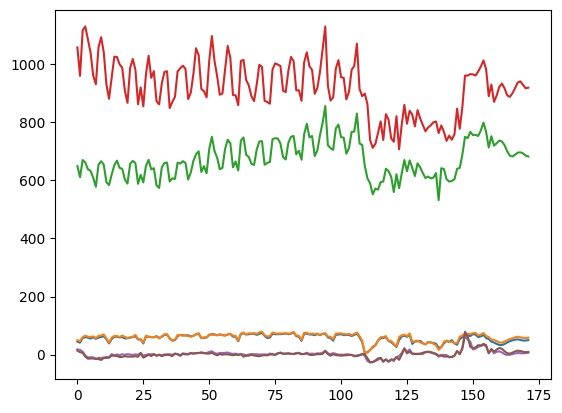

In [5]:
from matplotlib import pyplot as plt

imputation_ori = scalar.inverse_transform(imputation.squeeze(0))
plt.plot(imputation_ori)

In [10]:
df_pred = pd.DataFrame(imputation_ori,index=df_new.index,columns=df_new.columns)
tmp = pd.concat([df,df_pred])
df_pred = tmp.loc[~tmp.index.duplicated(keep='first')]
df_pred.to_csv('../data/raw/sh_hotel_pred.csv',index=True,index_label='日期')
df_pred

,平均出租率,五星级平均出租率,平均房价,五星级平均房价,平均房价增长,五星级房价增长
2024-02-01,44.599998,51.799999,752.000000,930.000000,17.000000,19.500000
2024-01-01,53.500000,60.200001,713.000000,890.000000,4.400000,5.200000
2023-12-01,57.099998,64.300003,767.000000,983.000000,28.100000,32.799999
2023-11-01,67.800003,74.099998,799.000000,1013.000000,33.500000,36.799999
2023-10-01,63.000000,69.199997,772.000000,992.000000,29.500000,31.600000
...,...,...,...,...,...,...
2024-12-01,52.429173,61.654625,695.507874,937.094727,5.666986,13.557571
2025-01-01,50.261002,59.693600,696.508301,940.948669,4.658452,12.184499
2025-02-01,48.290230,57.616779,692.958313,928.840759,4.526525,9.845591
2025-03-01,48.474064,57.258747,685.207703,917.108154,5.307562,8.189363
